+ 1）建立包含行人的一个图像数据库。这将作为我们的正数据样本。
+ 2）建立不包含行人的一个图像数据库。这将作为我们的负数据样本。
+ 3）在数据集上训练一个SVM。
+ 4）将SVM应用于每个可能的测试图像块，以确定整个图像是否包含一个行人。

## 获取数据集

In [1]:
datadir = "./data/chapter6"
dataset = "pedestrians128x64"
datafile = "%s/%s.tar.gz" % (datadir, dataset)
extractdir = "%s/%s" % (datadir, dataset)
def extract_tar(datafile, extractdir):
    try:
        import tarfile
    except ImportError:
        raise ImportError("You do not have tarfile installed. "
                          "Try unzipping the file outside of Python.")
    tar = tarfile.open(datafile)
    tar.extractall(path=extractdir)
    tar.close()
    print("%s successfully extracted to %s" % (datafile, extractdir))
extract_tar(datafile, datadir)

./data/chapter6/pedestrians128x64.tar.gz successfully extracted to ./data/chapter6


用OpenCV读取图像，并将图像的RGB版本传递给matplotlib来可视化一些示例图像：

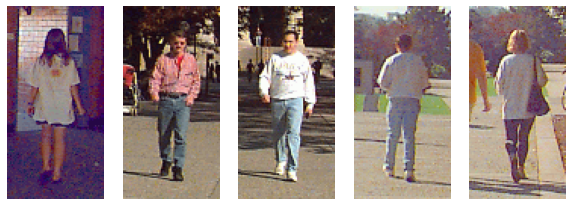

In [2]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 6))
for i in range(5):
    filename = "%s/per0010%d.ppm" % (extractdir, i)
    img = cv2.imread(filename)

    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

HOG是一种图像特征描述符，与我们在第4章中讨论过的内容类似。HOG已经成功地应用于各种计算机视觉任务，但是似乎特别适合于对人进行分类。

在OpenCV中，可以通过cv2.HOGDescriptor来访问HOG描述符，它接受一些输入参数，比如检测窗口大小（待检测物体的最小尺寸48×96）、块的大小（每个框的大小，16×16）、单元格大小（8×8）以及单元格步长（从一个单元格移动多少像素到下一个单元格，8×8）。对于每一个单元格，HOG描述符用9个bin计算一个面向梯度的直方图：

In [3]:
win_size = (48, 96)
block_size = (16, 16)
block_stride = (8, 8)
cell_size = (8, 8)
num_bins = 9
hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)

import numpy as np
import random
random.seed(42)
X_pos = []
for i in random.sample(range(1,900), 400):
    filename = "%s/per%05d.ppm" % (extractdir, i)
    img = cv2.imread(filename)
    if img is None:
        print('Could not find image %s' % filename)
        continue
    X_pos.append(hog.compute(img, (64, 64)))

X_pos = np.array(X_pos, dtype=np.float32)
y_pos = np.ones(X_pos.shape[0], dtype=np.int32)

## 生成负样本

In [4]:
negset = "pedestrians_neg"
negfile = "%s/%s.tar.gz" % (datadir, negset)
negdir = "%s/%s" % (datadir, negset)
extract_tar(negfile, datadir)

import os
hroi = 128
wroi = 64
X_neg = []
for negfile in os.listdir(negdir):
    filename = '%s/%s' % (negdir, negfile)
    img = cv2.imread(filename)
    img = cv2.resize(img, (512, 512))
    for j in range(5):
        rand_y = random.randint(0, img.shape[0] - hroi)
        rand_x = random.randint(0, img.shape[1] - wroi)
        roi = img[rand_y:rand_y + hroi, rand_x:rand_x + wroi, :]
        X_neg.append(hog.compute(roi, (64, 64)))

X_neg = np.array(X_neg, dtype=np.float32)
y_neg = -np.ones(X_neg.shape[0], dtype=np.int32)

./data/chapter6/pedestrians_neg.tar.gz successfully extracted to ./data/chapter6


把所有的正样本（X_pos）和负样本（X_neg）连接到一个数据集X中，我们利用非常熟悉的来自于scikit-learn的train_test_split函数对这个数据集进行拆分：

In [5]:
from sklearn import model_selection as ms
X = np.concatenate((X_pos, X_neg))
y = np.concatenate((y_pos, y_neg))
X_train, X_test, y_train, y_test = ms.train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 实现SVM

In [6]:
def train_svm(X_train, y_train):
    svm = cv2.ml.SVM_create()
    svm.train(X_train, cv2.ml.ROW_SAMPLE, y_train)
    return svm

def score_svm(svm, X, y):
    from sklearn import metrics
    _, y_pred = svm.predict(X)
    return metrics.accuracy_score(y, y_pred)

svm = train_svm(X_train, y_train)
score_svm(svm, X_train, y_train), score_svm(svm, X_test, y_test)

(1.0, 0.6615384615384615)

幸好有HOG特征描述符，我们在训练集上才不会出错。可是我们的泛化性能相当糟糕（只有64.6%），远远低于训练性能（100%）。这表明模型对数据是过拟合的。

## bootstrapping模型

In [7]:
# 1）对模型进行训练和评分，如下所示：
score_train = []
score_test = []
for j in range(3):
    svm = train_svm(X_train, y_train)
    score_train.append(score_svm(svm, X_train, y_train))
    score_test.append(score_svm(svm, X_test, y_test))
# 2）找出测试集中的假阳性。如果没有假阳性，那么我们的工作就完成了：
    _, y_pred = svm.predict(X_test)
    false_pos = np.logical_and((y_test.ravel() == -1), (y_pred.ravel() == 1))
    if not np.any(false_pos):
        print('done')
        break
# 3）把假阳性添加到训练集中，然后重复这个过程：
    X_train = np.concatenate((X_train, X_test[false_pos, :]), axis=0)
    y_train = np.concatenate((y_train, y_test[false_pos]), axis=0)

# 随着时间的推移，这能使我们提升模型的性能：
score_train, score_test

done


([1.0, 1.0], [0.6615384615384615, 1.0])

## 检测更大图像中的行人

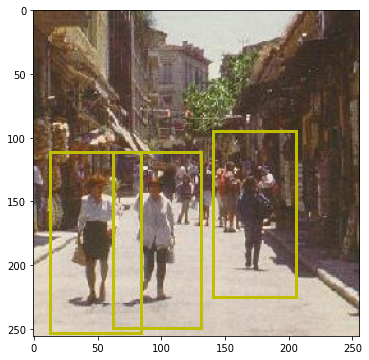

In [8]:
img_test = cv2.imread('./data/chapter6/pedestrian_test.jpg')
# 1）首先，我们必须循环遍历一张图像中的所有可能的块，如下所示，每次通过少数stride像素移动感兴趣区域：
stride = 16
found = []
for ystart in np.arange(0, img_test.shape[0], stride):
    for xstart in np.arange(0, img_test.shape[1], stride):
        # 2）我们希望确保不会超出图像的边界：
        if ystart + hroi > img_test.shape[0]:
            continue
        if xstart + wroi > img_test.shape[1]:
            continue
        # 3）然后，我们裁剪出感兴趣区域，进行预处理，并进行分类：
        roi = img_test[ystart:ystart + hroi, xstart:xstart + wroi, :]
        feat = np.array([hog.compute(roi, (64, 64))])
        _, ypred = svm.predict(feat)
        # 4）如果特定的图像块刚好被分类为一个行人，那么我们就把这个图像块添加到成功的列表里：
        if np.allclose(ypred, 1):
            found.append((ystart, xstart, hroi, wroi))

# 5）因为行人不但出现在不同的位置，而且大小也是各不相同，我们必须重新调整图像大小并重复整个过程。应该庆幸的是，OpenCV提供了一个方便的函数，以detectMultiScale函数的形式执行这个多尺度检测任务。这有点麻烦，但是我们可以把SVM的所有参数都传递给hog对象：
hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)
rho, _, _ = svm.getDecisionFunction(0)
sv = svm.getSupportVectors()
hog.setSVMDetector(np.append(sv[0, :].ravel(), rho))

# 6）然后就可以调用检测函数了：
found = hog.detectMultiScale(img_test)

# 7）在实践中，人们在面对一个标准任务（如行人检测）时，常常依赖于OpenCV中内置的预扫描SVM分类器。这就是我们在本章开头提到的方法。通过加载cv2.HOGDescriptor_getDaimlerPeopleDetector()或者cv2.HOGDescriptor_getDefaultPeopleDetector()，我们可以从几行代码开始：
hogdef = cv2.HOGDescriptor()
pdetect = cv2.HOGDescriptor_getDefaultPeopleDetector()
hogdef.setSVMDetector(pdetect)
found, _= hogdef.detectMultiScale(img_test)

# 8）使用matplotlib很容易绘制出测试图像，如下所示：
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))
from matplotlib import patches

# 9）然后，我们通过遍历found中的边框可以标记检测到的图像中的行人：
for f in found:
    ax.add_patch(patches.Rectangle((f[0], f[1]), f[2], f[3], color='y', linewidth=3, fill=False))